# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

  Using cached torch-2.10.0-cp313-cp313-win_amd64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp313-cp313-win_amd64.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached notebook-7.5.3-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.17.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab-4.


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms: ToTensor() converts PIL to tensor; Normalize with MNIST mean/std for stable training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Create training set and define training dataloader
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

# Create test set and define test dataloader
test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

100.0%
100.0%
100.0%
100.0%


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Because:

- **ToTensor()** converts each PIL image (0–255) into a `torch.Tensor` with values in [0, 1] and shape (C, H, W). This is required for PyTorch and keeps inputs on a consistent scale.
- **Normalize((0.1307,), (0.3081,))** uses the standard mean and standard deviation of the MNIST training set. Normalizing to zero mean and unit variance helps the optimizer converge faster and often improves accuracy, since gradients behave more stably and the network does not have to adapt to arbitrary input scales.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
Single image shape: torch.Size([1, 28, 28])

First 5 labels in batch: [9, 2, 5, 1, 0]
6


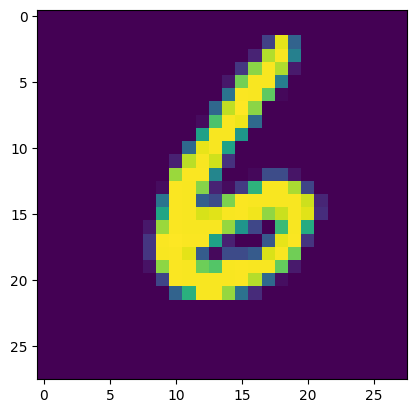

2


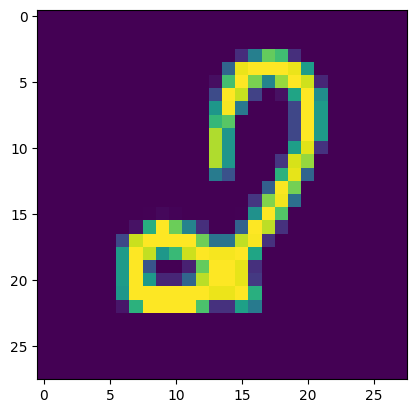

2


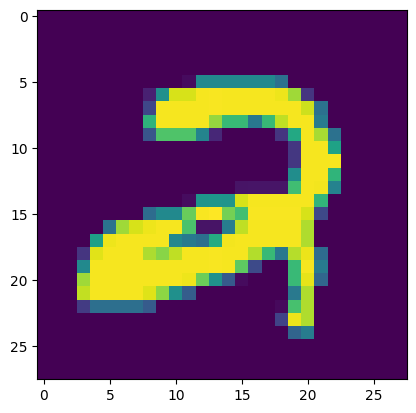

6


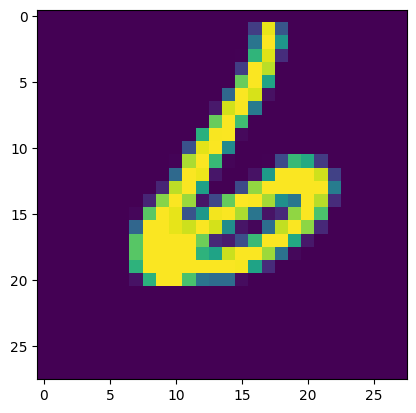

0


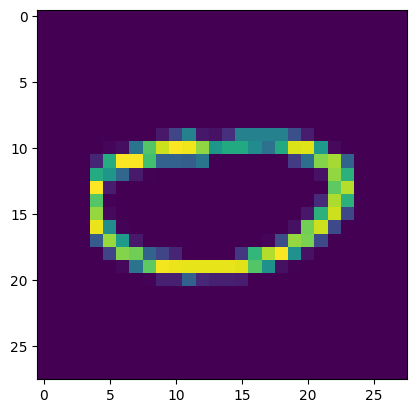

In [5]:
# Explore data: check shapes and show 5 sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Batch images shape:", images.shape)  # [batch, channels, height, width]
print("Batch labels shape:", labels.shape)
print("Single image shape:", images[0].shape)  # 1x28x28
print("\nFirst 5 labels in batch:", [int(labels[i]) for i in range(5)])
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# CrossEntropyLoss is standard for multi-class classification (includes softmax)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Model was already instantiated in the previous cell as `model`

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
train_losses = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 250 == 249:
            print(f"Epoch {epoch + 1}, batch {batch_idx + 1}: loss = {loss.item():.4f}")
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

Epoch 1, batch 250: loss = 0.2707
Epoch 1, batch 500: loss = 0.1874
Epoch 1, batch 750: loss = 0.1982
Epoch 1 average loss: 0.2325
Epoch 2, batch 250: loss = 0.0693
Epoch 2, batch 500: loss = 0.0790
Epoch 2, batch 750: loss = 0.0444
Epoch 2 average loss: 0.0928
Epoch 3, batch 250: loss = 0.0484
Epoch 3, batch 500: loss = 0.0656
Epoch 3, batch 750: loss = 0.0626
Epoch 3 average loss: 0.0636
Epoch 4, batch 250: loss = 0.0217
Epoch 4, batch 500: loss = 0.0218
Epoch 4, batch 750: loss = 0.0009
Epoch 4 average loss: 0.0509
Epoch 5, batch 250: loss = 0.0049
Epoch 5, batch 500: loss = 0.0140
Epoch 5, batch 750: loss = 0.0110
Epoch 5 average loss: 0.0377
Epoch 6, batch 250: loss = 0.0338
Epoch 6, batch 500: loss = 0.0626
Epoch 6, batch 750: loss = 0.0744
Epoch 6 average loss: 0.0338
Epoch 7, batch 250: loss = 0.0060
Epoch 7, batch 500: loss = 0.0068
Epoch 7, batch 750: loss = 0.0232
Epoch 7 average loss: 0.0284
Epoch 8, batch 250: loss = 0.0273
Epoch 8, batch 500: loss = 0.0045
Epoch 8, batch 

Plot the training loss (and validation loss/accuracy, if recorded).

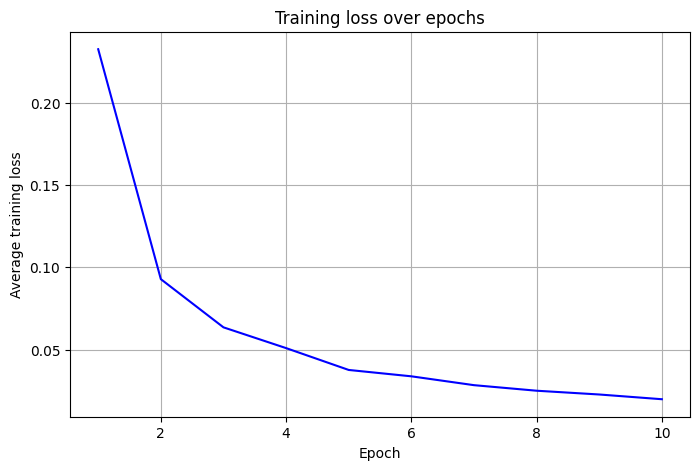

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Average training loss')
plt.title('Training loss over epochs')
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"Test accuracy: {accuracy:.2f}% ({correct}/{total})")

Test accuracy: 97.97% (9797/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [11]:
# Tweak hyperparameters and retrain to improve accuracy:
# - Lower learning rate for finer updates
# - Train for 5 additional epochs
optimizer_improved = optim.Adam(model.parameters(), lr=0.0005)
extra_epochs = 5
improved_losses = []

model.train()
for epoch in range(extra_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_improved.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_improved.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    improved_losses.append(avg_loss)
    print(f"Improvement epoch {epoch + 1}/{extra_epochs}, avg loss: {avg_loss:.4f}")

# Re-evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

improved_accuracy = 100 * correct / total
print(f"\nImproved test accuracy: {improved_accuracy:.2f}% ({correct}/{total})")

Improvement epoch 1/5, avg loss: 0.0083
Improvement epoch 2/5, avg loss: 0.0048
Improvement epoch 3/5, avg loss: 0.0039
Improvement epoch 4/5, avg loss: 0.0067
Improvement epoch 5/5, avg loss: 0.0041

Improved test accuracy: 98.36% (9836/10000)


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Save model state dict for future loading
torch.save(model.state_dict(), 'mnist_model.pth')
# To load later: model.load_state_dict(torch.load('mnist_model.pth'))